In [4]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [5]:
df = pd.read_csv("/content/complete_dataset.csv")

In [6]:
df=df.sort_values(by='date')
df.ffill(inplace=True)

In [7]:
df['date']=pd.to_datetime(df['date'])

In [8]:
df['day_of_week']=df['date'].dt.day_name()

In [9]:
df[['day_of_week','holiday','date']]

,day_of_week,holiday,date
0,Thursday,Y,2015-01-01
1,Friday,N,2015-01-02
2,Saturday,N,2015-01-03
3,Sunday,N,2015-01-04
4,Monday,N,2015-01-05
...,...,...,...
2101,Friday,N,2020-10-02
2102,Saturday,N,2020-10-03
2103,Sunday,N,2020-10-04
2104,Monday,N,2020-10-05


<Axes: xlabel='school_day'>

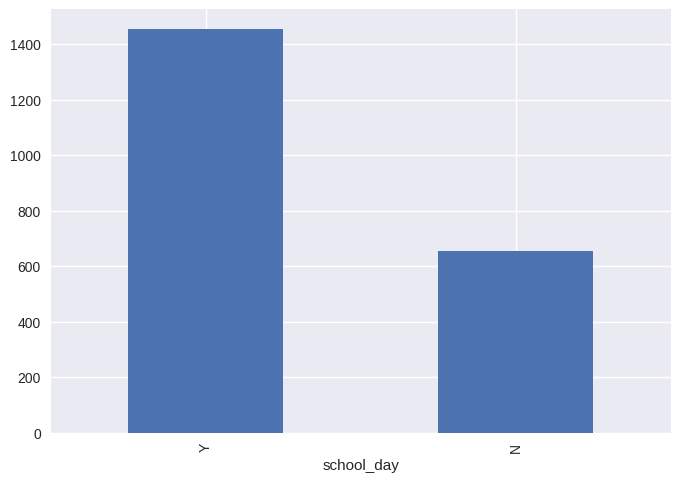

In [10]:
df['school_day'].value_counts().plot(kind='bar')

In [11]:
df

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,day_of_week
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y,Thursday
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N,Friday
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N,Saturday
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N,Sunday
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N,Friday
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N,Saturday
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N,Sunday
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N,Monday


In [12]:
ohe_Encoder=OneHotEncoder(drop='first',sparse_output=False).set_output(transform='pandas')
categorical_col=['school_day','holiday']
encoded_df=ohe_Encoder.fit_transform(df[categorical_col])
df=pd.concat([df,encoded_df],axis=1).drop(columns=categorical_col)

In [13]:
# df

In [14]:
# Rename columns for Prophet
df = df.rename(columns={"date": "ds", "demand": "y"})
df = df[["ds", "y", "min_temperature", "max_temperature", "solar_exposure", "RRP", "school_day_Y"]]

In [15]:
model = Prophet()
model.add_country_holidays(country_name='AU')
#model.add_regressor('min_temperature')
#model.add_regressor('max_temperature')
#model.add_regressor('solar_exposure')
#model.add_regressor('RRP')
#model.add_regressor('school_day_Y')

In [16]:
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/gabe6qqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/00jow7y9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60268', 'data', 'file=/tmp/tmpcv0_yyx6/gabe6qqy.json', 'init=/tmp/tmpcv0_yyx6/00jow7y9.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modelydn8skd_/prophet_model-20250404090330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
future=model.make_future_dataframe(periods=30)
future["min_temperature"] = df["min_temperature"].iloc[-1]
future["max_temperature"] = df["max_temperature"].iloc[-1]
future["solar_exposure"] = df["solar_exposure"].iloc[-1]
future["RRP"] = df["RRP"].iloc[-1]
future["school_day_Y"] = df["school_day_Y"].iloc[-1]

In [18]:
forecast=model.predict(future)

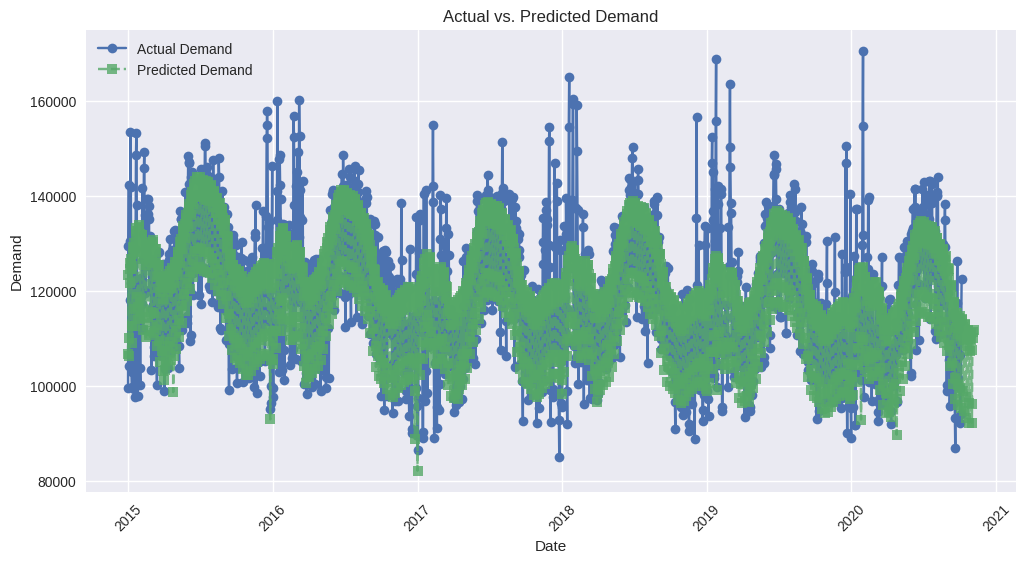

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df["ds"], df["y"], label="Actual Demand", marker='o', linestyle="-")
plt.plot(forecast["ds"], forecast["yhat"], label="Predicted Demand", marker='s', linestyle="--", alpha=0.8)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Actual vs. Predicted Demand")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get actuals and predictions from the DataFrames
actuals = df["y"].values  # Actual values from the original DataFrame

# Filter predictions to match the date range of actuals
predictions = forecast[forecast["ds"].isin(df["ds"])]["yhat"].values

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)

# Root Mean Squared Error (RMSE) - Option 1: Remove the squared argument
# rmse = mean_squared_error(actuals, predictions)  # This will calculate MSE

# Root Mean Squared Error (RMSE) - Option 2: Calculate RMSE directly
rmse = np.sqrt(mean_squared_error(actuals, predictions))  # This calculates RMSE

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


MAE: 6044.48, RMSE: 8413.20, MAPE: 5.03%


In [21]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming 'df' is your original DataFrame
# Split data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False) # Assuming you want a chronological split

# Prepare data for Prophet without regressors
train_prophet = train.reset_index().rename(columns={'date': 'ds', 'demand': 'y'})

# Initialize Prophet Model (NO regressors)
model_no_reg = Prophet()
model_no_reg.fit(train_prophet)

# Make Predictions
future_no_reg = model_no_reg.make_future_dataframe(periods=len(test))
forecast_no_reg = model_no_reg.predict(future_no_reg)

# Extract predictions
predictions_no_reg = forecast_no_reg['yhat'].iloc[-len(test):].values
# Access the 'y' column instead of 'demand' in the test DataFrame
actuals = test['y'].values

# Compute Evaluation Metrics
mae_no_reg = mean_absolute_error(actuals, predictions_no_reg)
rmse_no_reg = np.sqrt(mean_squared_error(actuals, predictions_no_reg))
mape_no_reg = np.mean(np.abs((actuals - predictions_no_reg) / actuals)) * 100

print(f"Without Regressors - MAE: {mae_no_reg:.2f}, RMSE: {rmse_no_reg:.2f}, MAPE: {mape_no_reg:.2f}%")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/t3evwvga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/q23cy6cd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81337', 'data', 'file=/tmp/tmpcv0_yyx6/t3evwvga.json', 'init=/tmp/tmpcv0_yyx6/q23cy6cd.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modela5jz2oid/prophet_model-20250404090331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Without Regressors - MAE: 6700.61, RMSE: 8810.26, MAPE: 5.82%


In [22]:
# Initialize model with regressors
model_with_reg = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative')

# Define the regressors you want to use
regressors = ["min_temperature", "max_temperature", "solar_exposure", "RRP", "school_day_Y"]

# Add regressors
for reg in regressors:
    model_with_reg.add_regressor(reg)

# Fit model
model_with_reg.fit(train)

# Future dataframe with regressors
future_with_reg = test[['ds'] + regressors]  # Use test data for future predictions
forecast_with_reg = model_with_reg.predict(future_with_reg)

# Extract predictions
predictions_with_reg = forecast_with_reg['yhat'].values
actuals = test['y'].values

# Evaluation metrics
mae_with_reg = mean_absolute_error(actuals, predictions_with_reg)
# Calculate RMSE by taking the square root of MSE
rmse_with_reg = np.sqrt(mean_squared_error(actuals, predictions_with_reg))
mape_with_reg = np.mean(np.abs((actuals - predictions_with_reg) / actuals)) * 100

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/2jqdruuj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/6guqltc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43179', 'data', 'file=/tmp/tmpcv0_yyx6/2jqdruuj.json', 'init=/tmp/tmpcv0_yyx6/6guqltc6.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modelg2ymj6_i/prophet_model-20250404090332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
# Initialize model without regressors
model_no_reg = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative')

# Fit model
model_no_reg.fit(train[['ds', 'y']])  # Only date and demand

# Future dataframe without regressors
future_no_reg = model_no_reg.make_future_dataframe(periods=len(test))
forecast_no_reg = model_no_reg.predict(future_no_reg)

# Extract predictions
predictions_no_reg = forecast_no_reg['yhat'].iloc[-len(test):].values
# Evaluation metrics
mae_no_reg = mean_absolute_error(actuals, predictions_no_reg)
# Calculate RMSE by taking the square root of MSE
rmse_no_reg = np.sqrt(mean_squared_error(actuals, predictions_no_reg))
mape_no_reg = np.mean(np.abs((actuals - predictions_no_reg) / actuals)) * 100


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/_jtcfzyx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/tysdsmvl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63450', 'data', 'file=/tmp/tmpcv0_yyx6/_jtcfzyx.json', 'init=/tmp/tmpcv0_yyx6/tysdsmvl.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modeltopu1mg7/prophet_model-20250404090332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


With Regressors - MAE: 6641.61, RMSE: 8147.37, MAPE: 5.83%
Without Regressors - MAE: 7012.74, RMSE: 9210.08, MAPE: 6.18%


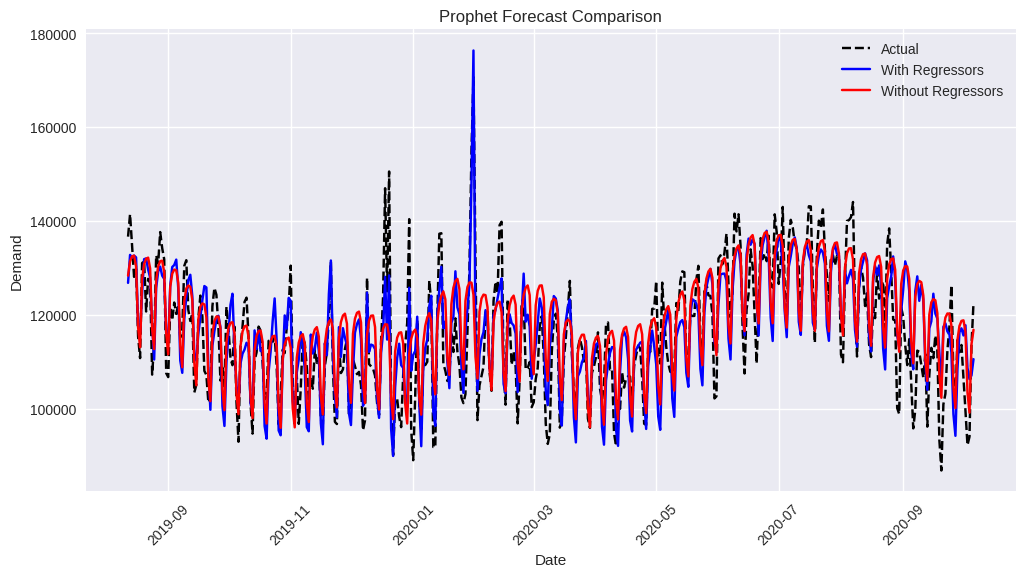

                Model          MAE         RMSE      MAPE
0     With Regressors  6641.608329  8147.370463  5.833292
1  Without Regressors  7012.743592  9210.080603  6.183609


In [24]:
# Print evaluation metrics
print(f"With Regressors - MAE: {mae_with_reg:.2f}, RMSE: {rmse_with_reg:.2f}, MAPE: {mape_with_reg:.2f}%")
print(f"Without Regressors - MAE: {mae_no_reg:.2f}, RMSE: {rmse_no_reg:.2f}, MAPE: {mape_no_reg:.2f}%")

# Plot Forecast Comparisons
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], actuals, label="Actual", color='black', linestyle='dashed')
plt.plot(test['ds'], predictions_with_reg, label="With Regressors", color='blue')
plt.plot(test['ds'], predictions_no_reg, label="Without Regressors", color='red')
plt.legend()
plt.title("Prophet Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.show()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': ['With Regressors', 'Without Regressors'],
    'MAE': [mae_with_reg, mae_no_reg],
    'RMSE': [rmse_with_reg, rmse_no_reg],
    'MAPE': [mape_with_reg, mape_no_reg]
})

# Display table
print(comparison_df)


In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
!pip install --upgrade scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics

# Load dataset
df = pd.read_csv("complete_dataset.csv")  # Update with actual file path
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# If you have separate min_temperature and max_temperature, you could create:
df['temperature'] = (df['min_temperature'] + df['max_temperature']) / 2

# Add custom regressors (weekday and is_weekend)
df['weekday'] = df['ds'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Remove 'holiday' as it's already one-hot encoded
regressors = ['temperature', 'RRP', 'weekday', 'is_weekend']

# Ensure all regressors are numeric
for reg in regressors:
    df[reg] = pd.to_numeric(df[reg], errors='coerce') # Convert to numeric, handle errors

# Train-Test Split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]  # Now train and test include all regressors

# Optimized Prophet Model with Regressors
model_with_reg = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=15,
    seasonality_mode='multiplicative'
)

# Adding regressors and seasonalities
for reg in regressors:
    model_with_reg.add_regressor(reg)

model_with_reg.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model_with_reg.add_seasonality(name='quarterly', period=91.25, fourier_order=10)

# Fit model with train data
model_with_reg.fit(train)

# Predict on test set
future_with_reg = test[['ds'] + regressors]
forecast_with_reg = model_with_reg.predict(future_with_reg)

# Evaluation with regressors
predictions_with_reg = forecast_with_reg['yhat'].values
actuals = test['y'].values
mae_with_reg = mean_absolute_error(actuals, predictions_with_reg)
rmse_with_reg = np.sqrt(mean_squared_error(actuals, predictions_with_reg))
mape_with_reg = np.mean(np.abs((actuals - predictions_with_reg) / actuals)) * 100


# **Model Comparison**
comparison_df = pd.DataFrame({
    'Model': ['With Regressors (Optimized)', 'Without Regressors (Optimized)'],
    'MAE': [mae_with_reg, mae_no_reg],
    'RMSE': [rmse_with_reg, rmse_no_reg],
    'MAPE': [mape_with_reg, mape_no_reg]
})

print(comparison_df)

# **Hyperparameter Tuning using Cross-validation**
cv_results = cross_validation(model_with_reg, horizon='30 days')
performance = performance_metrics(cv_results)
print(performance[['horizon', 'mae', 'rmse', 'mape']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/w536o_85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/8k78hzfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46828', 'data', 'file=/tmp/tmpcv0_yyx6/w536o_85.json', 'init=/tmp/tmpcv0_yyx6/8k78hzfc.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modeldznkio71/prophet_model-20250404090337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                            Model          MAE         RMSE      MAPE
0     With Regressors (Optimized)  7018.679109  8813.769636  6.133845
1  Without Regressors (Optimized)  7012.743592  9210.080603  6.183609


INFO:prophet:Making 86 forecasts with cutoffs between 2016-01-14 00:00:00 and 2019-07-12 00:00:00


  0%|          | 0/86 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/tt0_jaa1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/gpws06q0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9795', 'data', 'file=/tmp/tmpcv0_yyx6/tt0_jaa1.json', 'init=/tmp/tmpcv0_yyx6/gpws06q0.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modelvgzmexqj/prophet_model-20250404090338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/jp86k0vx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/b5mehbo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

   horizon          mae          rmse      mape
0   3 days  6097.728890   7820.282716  0.050429
1   4 days  6355.032498   8282.094594  0.052766
2   5 days  6464.445600   8427.324136  0.053756
3   6 days  6556.404288   8567.001217  0.054670
4   7 days  6656.951647   8622.606652  0.055984
5   8 days  6658.030816   8880.607234  0.056289
6   9 days  6659.222243   8744.825048  0.056030
7  10 days  6819.945500   9062.361342  0.056483
8  11 days  8020.964703  18454.890710  0.064293
9  12 days  8253.467195  18583.487403  0.066269
10 13 days  8245.340250  18498.588985  0.066912
11 14 days  7287.356365   9240.601123  0.061269
12 15 days  7590.239213  11377.189734  0.062755
13 16 days  7534.009222  11356.772774  0.061449
14 17 days  7521.215790  11283.135139  0.061006
15 18 days  7305.678296   9217.370968  0.060434
16 19 days  7315.040923   9247.960762  0.060998
17 20 days  7092.683987   9019.365214  0.059194
18 21 days  6934.427781   8998.411989  0.057915
19 22 days  7002.683757   9059.750602  0

In [26]:
import pandas as pd
import numpy as np
from prophet import Prophet
!pip install --upgrade scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics

# Load dataset
df = pd.read_csv("complete_dataset.csv")  # Update with actual file path
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# If you have separate min_temperature and max_temperature, you could create:
df['temperature'] = (df['min_temperature'] + df['max_temperature']) / 2

# Add custom regressors (weekday and is_weekend)
df['weekday'] = df['ds'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Remove 'holiday' as it's already one-hot encoded
regressors = ['temperature', 'RRP', 'weekday', 'is_weekend']

# Ensure all regressors are numeric
for reg in regressors:
    df[reg] = pd.to_numeric(df[reg], errors='coerce') # Convert to numeric, handle errors

# Remove Outliers (IQR Method)
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['y'] >= (Q1 - 1.5 * IQR)) & (df['y'] <= (Q3 + 1.5 * IQR))]

# Add Lag Features
df['y_lag1'] = df['y'].shift(1)
df['y_lag7'] = df['y'].shift(7)
df['rolling_mean_7'] = df['y'].rolling(7).mean()

# Drop rows with NaN values after creating lag features
df.dropna(inplace=True)

# Train-Test Split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]  # Now train and test include all regressors

# Optimized Prophet Model with Regressors
model_with_reg = Prophet(
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=15,
    seasonality_mode='multiplicative'
)

# Adding regressors and seasonalities
for reg in regressors + ['y_lag1', 'y_lag7', 'rolling_mean_7']:
    model_with_reg.add_regressor(reg)

model_with_reg.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model_with_reg.add_seasonality(name='quarterly', period=91.25, fourier_order=10)

# Fit model with train data
model_with_reg.fit(train)

# Predict on test set
future_with_reg = test[['ds'] + regressors + ['y_lag1', 'y_lag7', 'rolling_mean_7']]
forecast_with_reg = model_with_reg.predict(future_with_reg)

# Evaluation with regressors
predictions_with_reg = forecast_with_reg['yhat'].values
actuals = test['y'].values
mae_with_reg = mean_absolute_error(actuals, predictions_with_reg)
rmse_with_reg = np.sqrt(mean_squared_error(actuals, predictions_with_reg))
mape_with_reg = np.mean(np.abs((actuals - predictions_with_reg) / actuals)) * 100

# **Hyperparameter Tuning using Cross-validation**
cv_results = cross_validation(model_with_reg, initial='180 days', period='30 days', horizon='30 days')
performance = performance_metrics(cv_results)
print(performance[['horizon', 'mae', 'rmse', 'mape']])

# **Model Comparison**
comparison_df = pd.DataFrame({
    'Model': ['With Regressors (Optimized)'],
    'MAE': [mae_with_reg],
    'RMSE': [rmse_with_reg],
    'MAPE': [mape_with_reg]
})

print(comparison_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/sgyvk2in.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/e_j7ukv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2236', 'data', 'file=/tmp/tmpcv0_yyx6/sgyvk2in.json', 'init=/tmp/tmpcv0_yyx6/e_j7ukv3.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modelrofbj3ut/prophet_model-20250404090505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs between 2015-08-04 00:00:00 and 2019-07-14 00:00:00


  0%|          | 0/49 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/x44dfkwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/oa03mu3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44734', 'data', 'file=/tmp/tmpcv0_yyx6/x44dfkwh.json', 'init=/tmp/tmpcv0_yyx6/oa03mu3y.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modelbwg3itbf/prophet_model-20250404090506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/omm1jrep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/8olh6woc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

   horizon           mae          rmse      mape
0   3 days   4971.548423   6404.616316  0.041828
1   4 days   5447.511564   7383.697024  0.045875
2   5 days   6105.592896   8824.316558  0.051475
3   6 days   6462.178165   9836.773959  0.054209
4   7 days   6796.776240  10986.002191  0.056175
5   8 days   7581.421853  12340.733685  0.061633
6   9 days   9612.493621  21605.076469  0.076156
7  10 days  10450.245703  22488.726557  0.083528
8  11 days  10620.070516  23200.623691  0.086437
9  12 days  10548.268228  19166.885615  0.087895
10 13 days  10867.314859  21142.639650  0.089339
11 14 days  11638.896987  23278.965645  0.093722
12 15 days  11323.044973  23994.392128  0.090847
13 16 days  12082.434667  25091.654439  0.097170
14 17 days  12248.695052  25711.076127  0.099413
15 18 days  12520.702273  26079.177539  0.102813
16 19 days  12204.918815  26125.407728  0.101853
17 20 days  12478.847144  27306.496106  0.104572
18 21 days  12908.627725  28349.221496  0.107338
19 22 days  13130.58

In [27]:
import pandas as pd
import numpy as np
from prophet import Prophet
!pip install --upgrade scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics

# Load dataset
df = pd.read_csv("complete_dataset.csv")  # Update with actual file path
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date': 'ds', 'demand': 'y'}, inplace=True)

# If you have separate min_temperature and max_temperature, you could create:
df['temperature'] = (df['min_temperature'] + df['max_temperature']) / 2

# Add custom regressors (weekday and is_weekend)
df['weekday'] = df['ds'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Remove 'holiday' as it's already one-hot encoded
regressors = ['temperature', 'RRP', 'weekday', 'is_weekend']

# Ensure all regressors are numeric
for reg in regressors:
    df[reg] = pd.to_numeric(df[reg], errors='coerce') # Convert to numeric, handle errors

# Remove Outliers (IQR Method)
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['y'] >= (Q1 - 1.5 * IQR)) & (df['y'] <= (Q3 + 1.5 * IQR))]

# Add Lag Features
df['y_lag1'] = df['y'].shift(1)
df['y_lag7'] = df['y'].shift(7)
df['y_lag14'] = df['y'].shift(14)
df['y_lag30'] = df['y'].shift(30)
df['rolling_mean_7'] = df['y'].rolling(7).mean()
df['rolling_mean_14'] = df['y'].rolling(14).mean()
df['rolling_mean_30'] = df['y'].rolling(30).mean()

# Drop rows with NaN values after creating lag features
df.dropna(inplace=True) #This line was moved up

# Train-Test Split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]  # Now train and test include all regressors

# Optimized Prophet Model with Regressors
model_with_reg = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=15,
    seasonality_mode='multiplicative'
)

# Adding regressors and seasonalities
for reg in regressors + ['y_lag1', 'y_lag7', 'y_lag14', 'y_lag30', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30']:
    model_with_reg.add_regressor(reg)

model_with_reg.add_seasonality(name='weekly', period=7, fourier_order=3)
model_with_reg.add_seasonality(name='monthly', period=30.5, fourier_order=15)
model_with_reg.add_seasonality(name='quarterly', period=91.25, fourier_order=10)

# Fit model with train data
model_with_reg.fit(train)

# Predict on test set
future_with_reg = test[['ds'] + regressors + ['y_lag1', 'y_lag7', 'y_lag14', 'y_lag30', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30']]
forecast_with_reg = model_with_reg.predict(future_with_reg)

# Evaluation with regressors
predictions_with_reg = forecast_with_reg['yhat'].values
actuals = test['y'].values
mae_with_reg = mean_absolute_error(actuals, predictions_with_reg)
rmse_with_reg = np.sqrt(mean_squared_error(actuals, predictions_with_reg))
mape_with_reg = np.mean(np.abs((actuals - predictions_with_reg) / actuals)) * 100

# **Hyperparameter Tuning using Cross-validation**
cv_results = cross_validation(model_with_reg, initial='180 days', period='30 days', horizon='30 days')
performance = performance_metrics(cv_results)
print(performance[['horizon', 'mae', 'rmse', 'mape']])

# **Model Comparison**
comparison_df = pd.DataFrame({
    'Model': ['With Regressors (Optimized)'],
    'MAE': [mae_with_reg],
    'RMSE': [rmse_with_reg],
    'MAPE': [mape_with_reg]
})

print(comparison_df)

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/rqq9x_xe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/egi5f0q9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85128', 'data', 'file=/tmp/tmpcv0_yyx6/rqq9x_xe.json', 'init=/tmp/tmpcv0_yyx6/egi5f0q9.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modelwwsl4g9k/prophet_model-20250404090554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 49 forecasts with cutoffs b

  0%|          | 0/49 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/2b8774gq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/kjrde7m9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58441', 'data', 'file=/tmp/tmpcv0_yyx6/2b8774gq.json', 'init=/tmp/tmpcv0_yyx6/kjrde7m9.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modeloxzd93n3/prophet_model-20250404090555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/xozfsc_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/vobeiey4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

   horizon           mae           rmse      mape
0   3 days   6414.890909    9963.592129  0.052675
1   4 days   8882.171213   21183.474234  0.071143
2   5 days  10009.127360   23606.363799  0.081833
3   6 days  10562.583914   26170.752105  0.087757
4   7 days  10471.482966   24600.597936  0.088203
5   8 days  10888.542748   28259.042741  0.088995
6   9 days  11890.339830   33211.210196  0.094288
7  10 days  12562.203166   38501.582908  0.097752
8  11 days  14417.259842   45193.063981  0.114704
9  12 days  15755.052891   51749.107032  0.130761
10 13 days  17119.280982   58615.502635  0.145459
11 14 days  18695.290270   66861.921986  0.157604
12 15 days  20145.555447   73447.992978  0.164267
13 16 days  21605.384368   80099.903433  0.171946
14 17 days  22658.306389   86122.628680  0.178717
15 18 days  23944.019573   93253.213678  0.193460
16 19 days  25050.433275   99585.121156  0.211291
17 20 days  25982.549603  104993.436245  0.222059
18 21 days  27283.454033  109893.110497  0.231002


<ipython-input-28-9d1bdb4c6c0e>:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-28-9d1bdb4c6c0e>:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']].fillna(method='bfill', inplace=True)
<ipython-input-28-9d1bdb4c6c0e>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

NaN count before dropping:
demand                   0
demand_lag_1             0
demand_lag_7             0
rrp                      0
rrp_lag_1                0
rrp_lag_7                0
min_temperature          0
max_temperature          0
solar_exposure           0
rainfall                 0
temp_rain_interaction    0
dtype: int64
Train size: (1633, 16), Test size: (409, 16)
     demand  demand_lag_1  demand_lag_7       rrp  rrp_lag_1  rrp_lag_7  \
0 -2.095402     -0.001690     -0.001231 -1.397133  -0.001303  -0.000909   
1 -1.846017     -1.051484     -0.001231 -1.407423  -0.701162  -0.000909   
2 -1.274231     -1.234831     -0.001231 -1.392084  -0.941318  -0.000909   
3 -0.655335     -0.959285     -0.001231 -1.347080  -1.047298  -0.000909   
4 -0.043026     -0.527029     -0.001231 -1.203212  -1.080970  -0.000909   

   min_temperature  max_temperature  solar_exposure  rainfall  \
0         0.561157         1.548213        1.423300 -0.808292   
1         0.997533         0.935987  

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/x57w1ak5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24294', 'data', 'file=/tmp/tmpcv0_yyx6/5y3nruu_.json', 'init=/tmp/tmpcv0_yyx6/x57w1ak5.json', 'output', 'file=/tmp/tmpcv0_yyx6/prophet_modell5w7lsgw/prophet_model-20250404090638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:06:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/bkmjpua6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcv0_yyx6/qdifcy1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

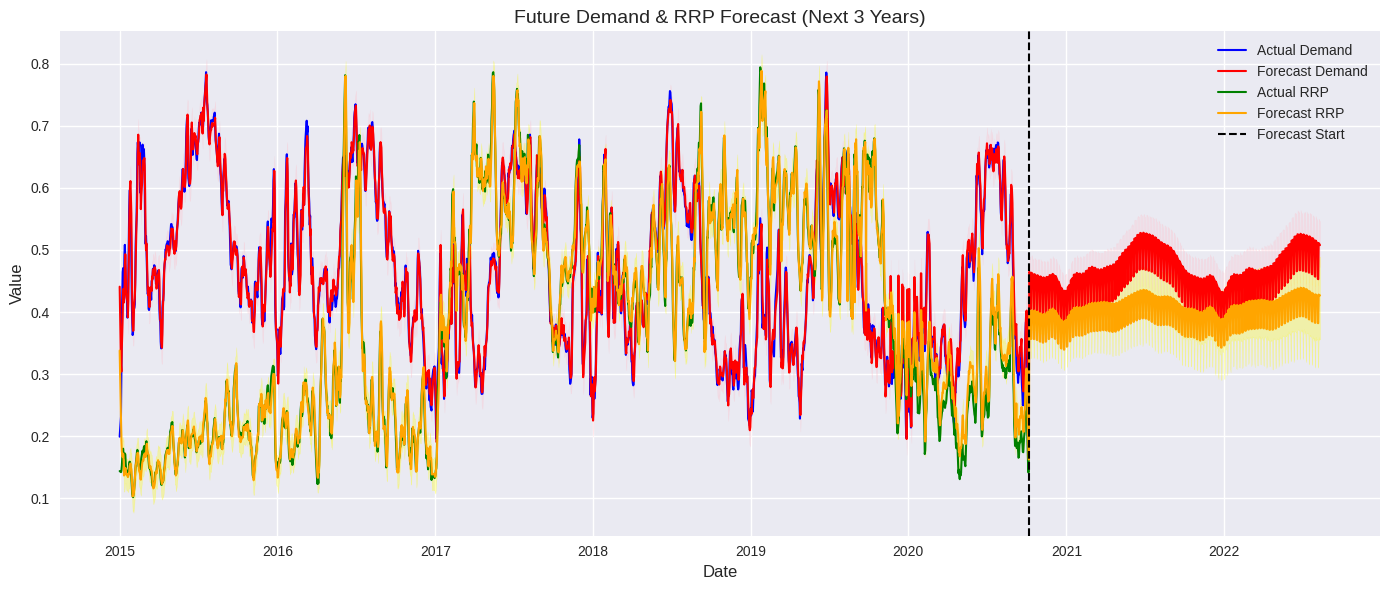

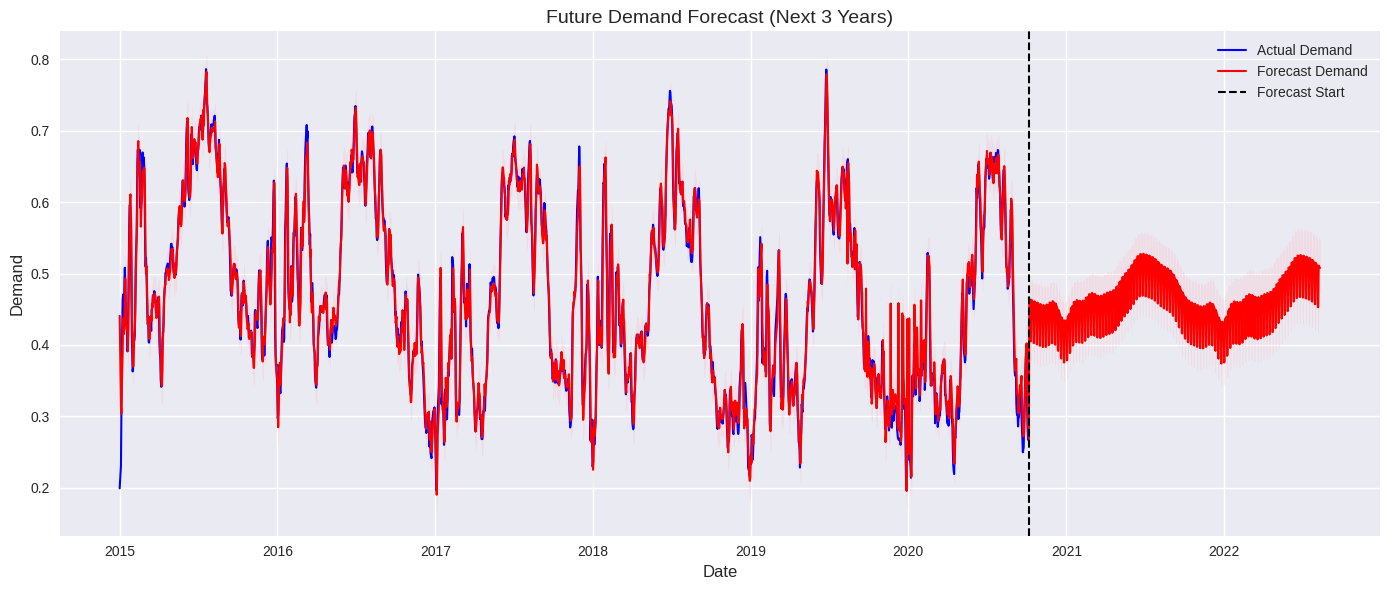

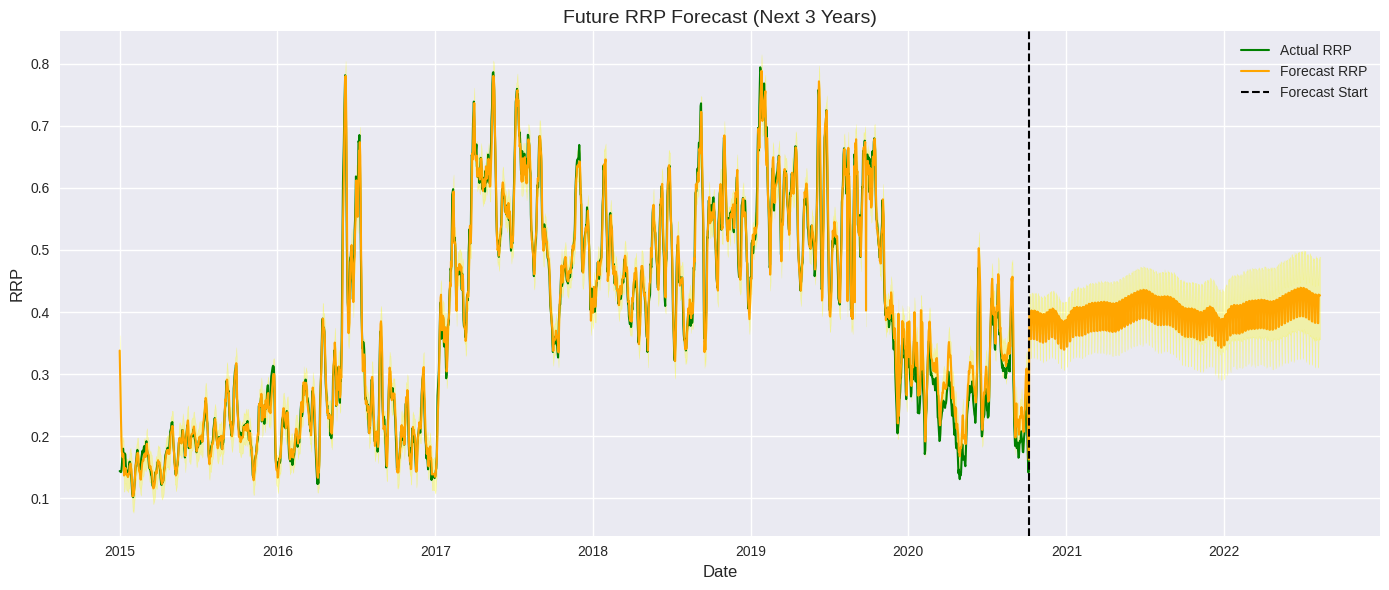

Demand Forecast Accuracy (Prophet):
MAE: 0.0163, RMSE: 0.0207

RRP Forecast Accuracy (Prophet):
MAE: 0.0274, RMSE: 0.0323

Additional Accuracy Evaluation (Percentage Range) - Prophet:
Demand Accuracy: 95.59%, RRP Accuracy: 89.90%


In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Load dataset
df = pd.read_csv('./cleaned_dataset_2.csv')

# Ensure date column is present and valid
if 'date' not in df.columns or df['date'].isna().all():
    print("🚨 Date column is missing! Reconstructing...")
    df['date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
else:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create lag features for demand and rrp
df['demand_lag_1'] = df['demand'].shift(1)
df['demand_lag_7'] = df['demand'].shift(7)
df['rrp_lag_1'] = df['rrp'].shift(1)
df['rrp_lag_7'] = df['rrp'].shift(7)

# Create interaction term for weather effects
df['temp_rain_interaction'] = df['min_temperature'] * df['rainfall']

df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['extreme_weather'] = ((df['max_temperature'] > df['max_temperature'].quantile(0.95)) |
                         (df['rainfall'] > df['rainfall'].quantile(0.95))).astype(int)

df['ds'] = df['date'].copy()
df = df.dropna(subset=['ds'])

# Scaling
scaler = StandardScaler()
features_to_scale = ['demand', 'demand_lag_1', 'demand_lag_7', 'rrp', 'rrp_lag_1', 'rrp_lag_7',
                     'min_temperature', 'max_temperature', 'solar_exposure',
                     'rainfall', 'temp_rain_interaction']

# Fill missing values using column mean before rolling mean
for col in features_to_scale:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].rolling(window=7, min_periods=1).mean()

# Handle lags properly
df[['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7']].fillna(method='bfill', inplace=True)

# Forward and backward fill any remaining NaNs
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Debug: Check for NaNs before dropping rows
nan_report = df[features_to_scale].isna().sum()
print("NaN count before dropping:")
print(nan_report)

if nan_report.sum() > 0:
    print(f"🚨 Remaining NaNs (after all filling attempts):\n{nan_report}")

df = df.dropna(subset=features_to_scale)
if df.empty:
    raise ValueError("🚨 All rows have NaNs after preprocessing! Check data integrity.")

# Scale features
scaled_features = scaler.fit_transform(df[features_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=features_to_scale)
scaled_df['is_weekend'] = df['is_weekend'].values
scaled_df['extreme_weather'] = df['extreme_weather'].values
scaled_df['ds'] = df['ds'].values
scaled_df['y_demand'] = df['demand'].values
scaled_df['y_rrp'] = df['rrp'].values
scaled_df = scaled_df.dropna(subset=['y_demand', 'y_rrp'])
scaled_df['ds'] = pd.to_datetime(scaled_df['ds'])

# Split Data
train_size = int(len(scaled_df) * 0.8)
train_df = scaled_df.iloc[:train_size]
test_df = scaled_df.iloc[train_size:]

print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")
print(train_df.head())

# Train Prophet Model for Demand
model_demand = Prophet()
regressor_cols = ['demand_lag_1', 'demand_lag_7', 'rrp_lag_1', 'rrp_lag_7',
                  'min_temperature', 'max_temperature', 'solar_exposure',
                  'rainfall', 'temp_rain_interaction', 'is_weekend', 'extreme_weather']
for col in regressor_cols:
    model_demand.add_regressor(col)

# Rename 'y_demand' to 'y' as required by Prophet
train_df_demand = train_df[['ds', 'y_demand'] + regressor_cols].rename(columns={'y_demand': 'y'})
# Fit the Prophet model for Demand
model_demand.fit(train_df_demand)

# Train Prophet Model for RRP
model_rrp = Prophet()
for col in regressor_cols:
    model_rrp.add_regressor(col)

# Rename 'y_rrp' to 'y' as required by Prophet
train_df_rrp = train_df[['ds', 'y_rrp'] + regressor_cols].rename(columns={'y_rrp': 'y'})
model_rrp.fit(train_df_rrp)

# # Save the models to disk
# with open('model_demand.pkl', 'wb') as f:
#     pickle.dump(model_demand, f)

# with open('model_rrp.pkl', 'wb') as f:
#     pickle.dump(model_rrp, f)

# Create a future dataframe for the next 3 years (1095 days)
future = model_demand.make_future_dataframe(periods=1095, freq='D')

# Merge the additional regressor data from scaled_df
future = future.merge(
    scaled_df[['ds'] + regressor_cols],
    on='ds', how='left', suffixes=('', '_new')
)

# Overwrite existing regressor columns if new values were merged
for col in regressor_cols:
    if col + '_new' in future.columns:
        future[col] = future[col + '_new']
        future.drop(columns=[col + '_new'], inplace=True)

# Fill any missing regressor values with the mean from scaled_df
for col in regressor_cols:
    future[col].fillna(scaled_df[col].mean(), inplace=True)

# Predict future demand and rrp
forecast_demand = model_demand.predict(future)
forecast_rrp = model_rrp.predict(future)

# Use a cleaner style for plots
plt.style.use('seaborn-v0_8')

# Plot actual vs. future forecasts for Demand and RRP
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['ds'], scaled_df['y_demand'], label='Actual Demand', color='blue', linewidth=1.5)
plt.plot(forecast_demand['ds'], forecast_demand['yhat'], label='Forecast Demand', color='red', linewidth=1.5)
plt.fill_between(
    forecast_demand['ds'],
    forecast_demand['yhat_lower'],
    forecast_demand['yhat_upper'],
    color='pink', alpha=0.3
)
plt.plot(scaled_df['ds'], scaled_df['y_rrp'], label='Actual RRP', color='green', linewidth=1.5)
plt.plot(forecast_rrp['ds'], forecast_rrp['yhat'], label='Forecast RRP', color='orange', linewidth=1.5)
plt.fill_between(
    forecast_rrp['ds'],
    forecast_rrp['yhat_lower'],
    forecast_rrp['yhat_upper'],
    color='yellow', alpha=0.3
)
plt.axvline(test_df['ds'].max(), color='black', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.title('Future Demand & RRP Forecast (Next 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Filter forecasts matching the test dates for both demand and rrp
test_forecast_demand = test_df[['ds', 'y_demand']].merge(
    forecast_demand[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds'
)
test_forecast_rrp = test_df[['ds', 'y_rrp']].merge(
    forecast_rrp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds'
)

# Compute accuracy metrics for Demand
mae_demand = mean_absolute_error(test_forecast_demand['y_demand'], test_forecast_demand['yhat'])
rmse_demand = np.sqrt(mean_squared_error(test_forecast_demand['y_demand'], test_forecast_demand['yhat']))

# Compute accuracy metrics for RRP
mae_rrp = mean_absolute_error(test_forecast_rrp['y_rrp'], test_forecast_rrp['yhat'])
rmse_rrp = np.sqrt(mean_squared_error(test_forecast_rrp['y_rrp'], test_forecast_rrp['yhat']))

# Plot Demand forecast with cleaner style
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['ds'], scaled_df['y_demand'], label='Actual Demand', color='blue', linewidth=1.5)
plt.plot(forecast_demand['ds'], forecast_demand['yhat'], label='Forecast Demand', color='red', linewidth=1.5)
plt.fill_between(
    forecast_demand['ds'],
    forecast_demand['yhat_lower'],
    forecast_demand['yhat_upper'],
    color='pink', alpha=0.3
)
plt.axvline(test_df['ds'].max(), color='black', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.title('Future Demand Forecast (Next 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Plot RRP forecast with cleaner style
plt.figure(figsize=(14, 6))
plt.plot(scaled_df['ds'], scaled_df['y_rrp'], label='Actual RRP', color='green', linewidth=1.5)
plt.plot(forecast_rrp['ds'], forecast_rrp['yhat'], label='Forecast RRP', color='orange', linewidth=1.5)
plt.fill_between(
    forecast_rrp['ds'],
    forecast_rrp['yhat_lower'],
    forecast_rrp['yhat_upper'],
    color='yellow', alpha=0.3
)
plt.axvline(test_df['ds'].max(), color='black', linestyle='--', label='Forecast Start', linewidth=1.5)
plt.title('Future RRP Forecast (Next 3 Years)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('RRP', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Print accuracy metrics using actual (unscaled) values
print("Demand Forecast Accuracy (Prophet):")
print(f"MAE: {mae_demand:.4f}, RMSE: {rmse_demand:.4f}")
print("\nRRP Forecast Accuracy (Prophet):")
print(f"MAE: {mae_rrp:.4f}, RMSE: {rmse_rrp:.4f}")

# Additional accuracy evaluation in percentage (100% range)
mape_demand = np.mean(np.abs((test_forecast_demand['y_demand'] - test_forecast_demand['yhat']) / test_forecast_demand['y_demand'])) * 100
mape_rrp = np.mean(np.abs((test_forecast_rrp['y_rrp'] - test_forecast_rrp['yhat']) / test_forecast_rrp['y_rrp'])) * 100
accuracy_demand = 100 - mape_demand
accuracy_rrp = 100 - mape_rrp

print("\nAdditional Accuracy Evaluation (Percentage Range) - Prophet:")
print(f"Demand Accuracy: {accuracy_demand:.2f}%, RRP Accuracy: {accuracy_rrp:.2f}%")